<a href="https://colab.research.google.com/github/YuriiKlim/AI/blob/Image_neural_1/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'leukemia-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F849724%2F1449674%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240808%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240808T175632Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7afad9e5e6ed28f5c8c018fe38881999b498be99b8889b9cb3cb9491f28de9b7b0a18a7543f15e8c9abd246d43c0a26c4a0e36215b2a8f689300b5a18369e03a4f4e24ef3f04f556873ece5829c31bdd9e5b5a0356d65171e7d4b99ea5187a6e39c0b8646ff78ec62f69b732b95951fa93c8350385dccf81dab0779de73556533e10e5d0c2e847eb6e022e254151134426a4d9b6327607017085c581887e9cee5cfd0365b50261c3f75f80523f145c8c0bb2ba71510ba83b4a7cac79f554883009774d4c7ef4822c746e0f0570b8171db8c47f4e15b5b39a82baa49c17e1f772e9ad4a7bc1139a5aa0ff9edb9c4925e3179ee028b476b602d80318d31ff740a8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", '/kaggle/input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", '/kaggle/input'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


The system cannot find the path specified.


[==================================================] 909211078 bytes downloaded
Downloaded and uncompressed: leukemia-classification
Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import torch
from torchvision import datasets, transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
data_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0'

dataset0 = datasets.ImageFolder(root=data_dir)

In [6]:
data_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1'

dataset1 = datasets.ImageFolder(root=data_dir)

In [7]:
data_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2'

dataset2 = datasets.ImageFolder(root=data_dir)

In [8]:
from torch.utils.data import ConcatDataset
dataset = ConcatDataset([dataset0, dataset1, dataset2])

len(dataset)

10661

In [9]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=450x450>, 0)

In [10]:
from torch.utils.data import random_split

train_ratio = 0.8

train_data, val_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [11]:
image_tensor, label = dataset[2]

In [12]:
from torchvision import models

resnet = models.resnet152(pretrained=True)
resnet

C:\Users\klimk\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\klimk\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to C:\Users\klimk/.cache\torch\hub\checkpoints\resnet152-394f9c45.pth
100%|███████████████████████████████████████████████████████████████████████████████| 230M/230M [00:02<00:00, 92.5MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
import torch.nn as nn
import torch.nn.functional as F


class TransferLearningClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        resnet = models.resnet152(pretrained=True)

        for param in resnet.parameters():
            param.requires_grad = False

        in_features = resnet.fc.in_features

        resnet.fc = nn.Identity()

        self.feature_extractor = resnet

        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(in_features, num_classes)

    def forward(self, x):
        out = self.feature_extractor(x)

        out = self.dropout(out)
        out = self.linear(out)

        return out

    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransferLearningClassifier(num_classes=len(dataset0.classes)).to(device)

In [14]:
train_transform = transforms.Compose([
    transforms.Resize((254, 254)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(-180, 180)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean=[0.0456, 0.0198, 0.0521], std=[0.1016, 0.0452, 0.1158])
    #transforms.Grayscale(num_output_channels=1)
])

test_transform = transforms.Compose([
    transforms.Resize((254, 254)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0456, 0.0198, 0.0521], std=[0.1016, 0.0452, 0.1158])
    #transforms.Grayscale(num_output_channels=1)
])

transform = transforms.Compose([
    transforms.Resize((254, 254)),
    transforms.ToTensor(),
])


class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.classes = dataset[label]

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


train_data = TransformDataset(train_data, transform = train_transform)
val_data = TransformDataset(val_data, transform = test_transform)

In [16]:
# means = []
# stds = []
# for img, _ in val_data:
#     means.append(torch.mean(img, [1, 2]).tolist())
#     stds.append(torch.std(img, [1, 2]).tolist())

# mean = torch.mean(torch.tensor(means), [0])
# std = torch.mean(torch.tensor(stds), [0])

# mean, std

In [17]:
len(train_data), len(val_data)

(8529, 2132)

In [18]:
dataset = TransformDataset(dataset, transform=transform)

In [19]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size)

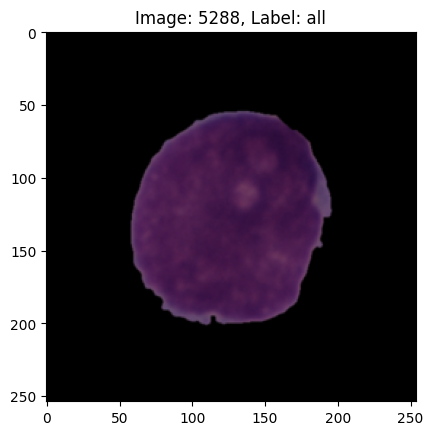

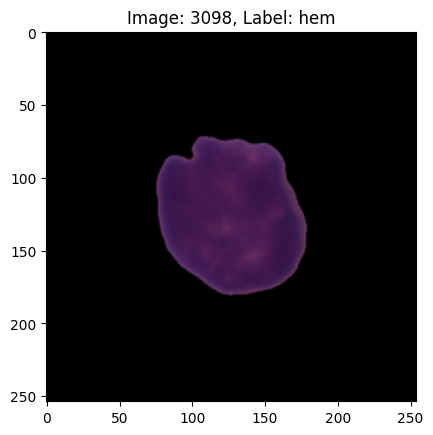

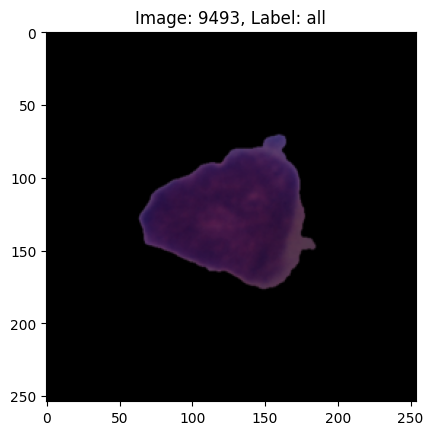

In [20]:
import matplotlib.pyplot as plt
import random

for _ in range(3):
    rand = random.randint(0, 10660)
    img, label = dataset[rand]

    img = img.numpy()

    img = img.transpose((1, 2, 0))

    label_name = dataset0.classes[label]

    plt.imshow(img)
    plt.title(f"Image: {rand+1}, Label: {label_name}")
    plt.show()

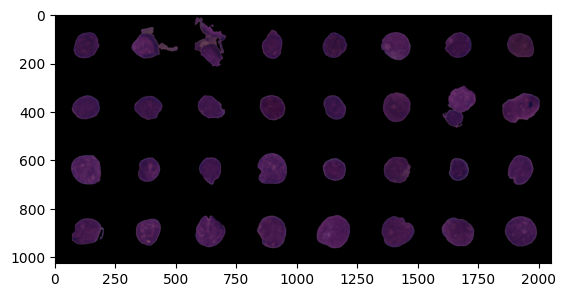

In [21]:
from torchvision.utils import make_grid

loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=32)

batch, labels = next(iter(loader))

grid = make_grid(batch).permute(1, 2, 0)

plt.imshow(grid)

In [22]:
#!pip install -q torchsummary

In [23]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [24]:
from collections import Counter

class_counts = Counter()
for _, label in dataset:
    class_counts[label] += 1

total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

weights = torch.tensor([class_weights[i] for i in range(len(class_counts))], dtype=torch.float32).to(device)
weights

tensor([1.4660, 3.1458], device='cuda:0')

In [25]:
loss_fn = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl, scheduler=None,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression', log_interval=1):
    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {}
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    model.to(device)

    start_time_train = time.time()

    for epoch in range(epochs):
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss'] + metrics_name}

        for batch in train_dl:
            x = batch[0].to(device)
            y = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    if func == roc_auc_score:
                        # Check if there are both classes present in y
                        if len(np.unique(y)) == 2:
                            history_train[name] += func(y, y_pred) * x.size(0)
                    else:
                        history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary':
                        y_pred_ = y_pred.round()
                    elif task == 'multiclass':
                        y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)

        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name + ['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x = batch[0].to(device)
                y = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        if func == roc_auc_score:
                            # Check if there are both classes present in y
                            if len(np.unique(y)) == 2:
                                history_val['val_' + name] += func(y, y_pred) * x.size(0)
                        else:
                            history_val['val_' + name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary':
                            y_pred_ = y_pred.round()
                        elif task == 'multiclass':
                            y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_' + name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_' + name].append(history_val['val_' + name])

        total_time_epoch = end_time_epoch - start_time_epoch

        if epoch + 1 == 1 or (epoch + 1) % log_interval == 0 or epoch + 1 == epochs:
            print(f'Epoch {epoch + 1:4d} {total_time_epoch:4.0f}sec', end='\t')
            for name in history_train:
                print(f'{name}: {history[name][-1]:10.3g}', end='\t')
                print(f"val_{name}: {history['val_' + name][-1]:10.3g}", end='\t')
            print()

        if scheduler:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(history_val['val_loss'][-1])
            else:
                scheduler.step()

    end_time_train = time.time()
    total_time_train = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [27]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, val_loader,
                epochs=20,
                metrics=[accuracy_score],
                device=device,
                task='multiclass',
               log_interval=2)

Epoch    1  145sec	loss:      0.518	val_loss:      0.497	accuracy_score:      0.764	val_accuracy_score:      0.697	
Epoch    2  142sec	loss:      0.473	val_loss:      0.421	accuracy_score:      0.788	val_accuracy_score:      0.829	
Epoch    4  142sec	loss:      0.483	val_loss:      0.416	accuracy_score:      0.786	val_accuracy_score:      0.847	
Epoch    6  141sec	loss:      0.455	val_loss:      0.419	accuracy_score:      0.801	val_accuracy_score:       0.81	
Epoch    8  141sec	loss:      0.473	val_loss:      0.443	accuracy_score:      0.794	val_accuracy_score:      0.754	
Epoch   10  138sec	loss:      0.484	val_loss:      0.445	accuracy_score:      0.785	val_accuracy_score:      0.743	
Epoch   12  139sec	loss:      0.452	val_loss:      0.393	accuracy_score:      0.803	val_accuracy_score:      0.842	
Epoch   14  137sec	loss:       0.46	val_loss:      0.424	accuracy_score:      0.799	val_accuracy_score:      0.786	
Epoch   16  137sec	loss:      0.458	val_loss:      0.405	accuracy_score:

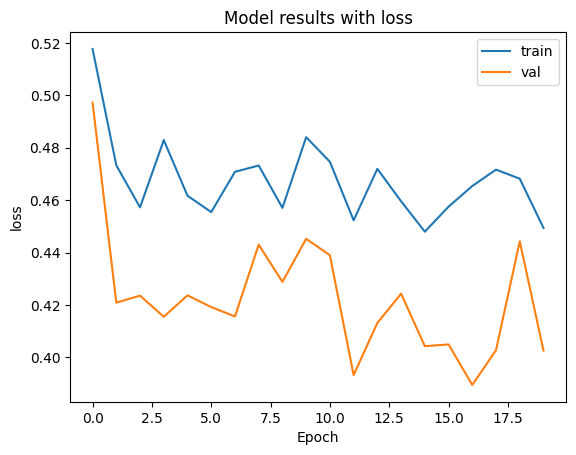

In [28]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

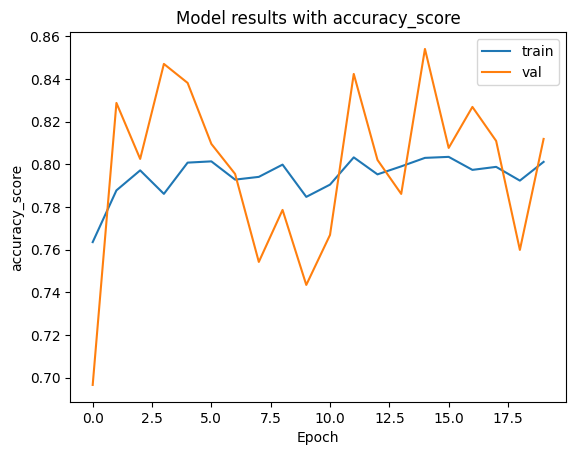

In [29]:
plot_metric(history, 'accuracy_score')

[]

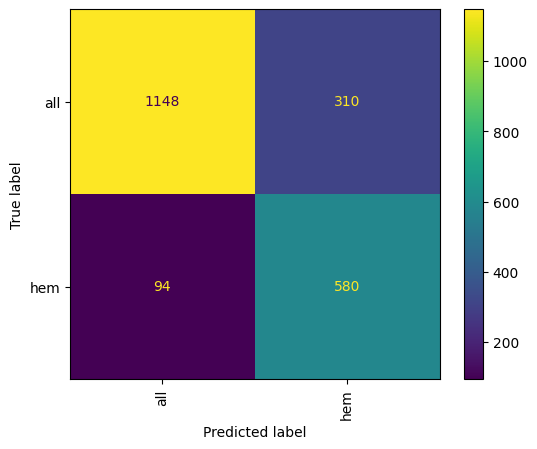

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')  # відключаємо від gpu

loader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1), display_labels=dataset0.classes)
plt.xticks(rotation=90)
plt.plot()